# HOUSE PRICE PREDICTION

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Download latest version
path = kagglehub.dataset_download("derrekdevon/real-estate-sales-2001-2020")

print("Path to dataset files:", path)

# Load data
file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, file))


Using Colab cache for faster access to the 'real-estate-sales-2001-2020' dataset.
Path to dataset files: /kaggle/input/real-estate-sales-2001-2020


### Data preprocessing

In [2]:

# ---- Quick info ----

print("== LOADED ROWS:", df.shape[0], "COLUMNS:", df.shape[1])
print(df.head())

print("\n== INFO == ")
df.info()
print("\n== BASIC SUMMARY STATS ==")
print(df.describe())



== LOADED ROWS: 997213 COLUMNS: 11
   Serial Number  List Year Date Recorded     Town                Address  \
0        2020348       2020     9/13/2021  Ansonia        230 WAKELEE AVE   
1          20002       2020     10/2/2020  Ashford        390 TURNPIKE RD   
2         200212       2020      3/9/2021     Avon       5 CHESTNUT DRIVE   
3         200243       2020     4/13/2021     Avon  111 NORTHINGTON DRIVE   
4         200377       2020      7/2/2021     Avon     70 FAR HILLS DRIVE   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0          150500     325000.0       0.4630    Commercial              Nan   
1          253000     430000.0       0.5883   Residential    Single Family   
2          130400     179900.0       0.7248   Residential            Condo   
3          619290     890000.0       0.6958   Residential    Single Family   
4          862330    1447500.0       0.5957   Residential    Single Family   

   Years until sold  
0          

In [3]:
# Years until sold.min() = -18 ??
print(df[df['Years until sold'] < 0][['List Year', 'Date Recorded']].head())

        List Year Date Recorded
388498       2006     2/26/2004
389700       2006      9/4/2001
407732       2006     7/17/2003
409330       2006     9/20/2005
410449       2006     9/25/2001


In [4]:
# Check Property Types and Residential Types
print("== PROPERTY TYPES ==")
print(df['Property Type'].unique())
print("\n== RESIDENTIAL TYPES ==")
print(df['Residential Type'].unique())

== PROPERTY TYPES ==
['Commercial' 'Residential' 'Vacant Land' 'Nan' 'Apartments' 'Industrial'
 'Public Utility' 'Condo' 'Two Family' 'Three Family' 'Single Family'
 'Four Family']

== RESIDENTIAL TYPES ==
['Nan' 'Single Family' 'Condo' 'Two Family' 'Three Family' 'Four Family']


In [5]:
for prop in df['Property Type'].unique():
  print(f"== {prop} ==")
  print(df[df['Property Type']== prop].sort_values(by='Property Type', ascending=False).head())
  print('\n')

== Commercial ==
       Serial Number  List Year Date Recorded          Town  \
0            2020348       2020     9/13/2021       Ansonia   
43135         200584       2020     3/22/2021     New Haven   
43057          20427       2020      4/9/2021       Newtown   
43027        2002395       2020     8/18/2021      Stamford   
43022       20200014       2020    12/14/2020  North Canaan   

                         Address  Assessed Value  Sale Amount  Sales Ratio  \
0                230 WAKELEE AVE          150500     325000.0     0.463000   
43135               9 ATWATER ST          261100     465000.0     0.561505   
43057  178-180 MAIN STREET SOUTH          242960     200000.0     1.214800   
43027      365 SYLVAN KNOLL ROAD        11259520     178500.0    63.078500   
43022        176 ASHLEY FALLS RD          134780     229000.0     0.588500   

      Property Type Residential Type  Years until sold  
0        Commercial              Nan                 1  
43135    Commercial  

In [6]:
# Clean data
def process_data(df):

    # Dates
    df['Date Recorded'] = pd.to_datetime(df['Date Recorded'], errors='coerce')
    invalid_years = df['List Year'] > df['Date Recorded'].dt.year
    df.loc[invalid_years, 'List Year'] = df.loc[invalid_years, 'Date Recorded'].dt.year
    df['Year Sold'] = df['Date Recorded'].dt.year
    df['Years until sold'] = df['Date Recorded'].dt.year.values - df['List Year'].values

    # Property and Residential types
    df['Property Type'] = df['Property Type'].replace('Nan', 'Other')
    df['Residential Type'] = df['Residential Type'].replace('Nan', 'N/A')

    residential_types = ['Single Family', 'Condo', 'Two Family', 'Three Family', 'Four Family',
        'Vacant Land', 'Apartments']
    for r_type in residential_types:
      df.loc[df['Property Type'].isin([r_type]), 'Residential Type'] = r_type

    df.loc[df['Property Type'].isin(residential_types), 'Property Type'] = 'Residential'


    df[['Property Type', 'Residential Type']] = df[['Property Type', 'Residential Type']].astype('category')


    return df

In [7]:
df_1 = process_data(df)
print(df_1.head())

   Serial Number  List Year Date Recorded     Town                Address  \
0        2020348       2020    2021-09-13  Ansonia        230 WAKELEE AVE   
1          20002       2020    2020-10-02  Ashford        390 TURNPIKE RD   
2         200212       2020    2021-03-09     Avon       5 CHESTNUT DRIVE   
3         200243       2020    2021-04-13     Avon  111 NORTHINGTON DRIVE   
4         200377       2020    2021-07-02     Avon     70 FAR HILLS DRIVE   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0          150500     325000.0       0.4630    Commercial              N/A   
1          253000     430000.0       0.5883   Residential    Single Family   
2          130400     179900.0       0.7248   Residential            Condo   
3          619290     890000.0       0.6958   Residential    Single Family   
4          862330    1447500.0       0.5957   Residential    Single Family   

   Years until sold  Year Sold  
0                 1       2021  
1 

In [8]:
print(df_1[['Property Type', 'Residential Type']].value_counts())

Property Type   Residential Type
Residential     Single Family       445016
Other           N/A                 382446
Residential     Condo               117780
                Two Family           29609
                Three Family         14081
                Vacant Land           3163
                Four Family           2418
Commercial      N/A                   1981
Residential     Apartments             486
Industrial      N/A                    228
Public Utility  N/A                      5
Name: count, dtype: int64


In [9]:
print(df_1.describe())

       Serial Number      List Year                  Date Recorded  \
count   9.972130e+05  997213.000000                         997213   
mean    4.311864e+05    2010.189609  2011-06-19 11:36:47.021769216   
min     0.000000e+00    1999.000000            1999-04-05 00:00:00   
25%     3.044400e+04    2004.000000            2005-07-25 00:00:00   
50%     7.030300e+04    2010.000000            2011-01-19 00:00:00   
75%     1.518780e+05    2016.000000            2017-04-05 00:00:00   
max     2.000500e+09    2020.000000            2021-09-30 00:00:00   
std     6.549219e+06       6.237850                            NaN   

       Assessed Value   Sale Amount   Sales Ratio  Years until sold  \
count    9.972130e+05  9.972130e+05  9.972130e+05     997213.000000   
mean     2.791437e+05  3.911512e+05  1.044637e+01          0.751119   
min      0.000000e+00  0.000000e+00  0.000000e+00          0.000000   
25%      8.760000e+04  1.400000e+05  4.867000e-01          1.000000   
50%      1.383

### EDA

Text(0.5, 1.0, 'Average Sale Price and Assessed amount by Year')

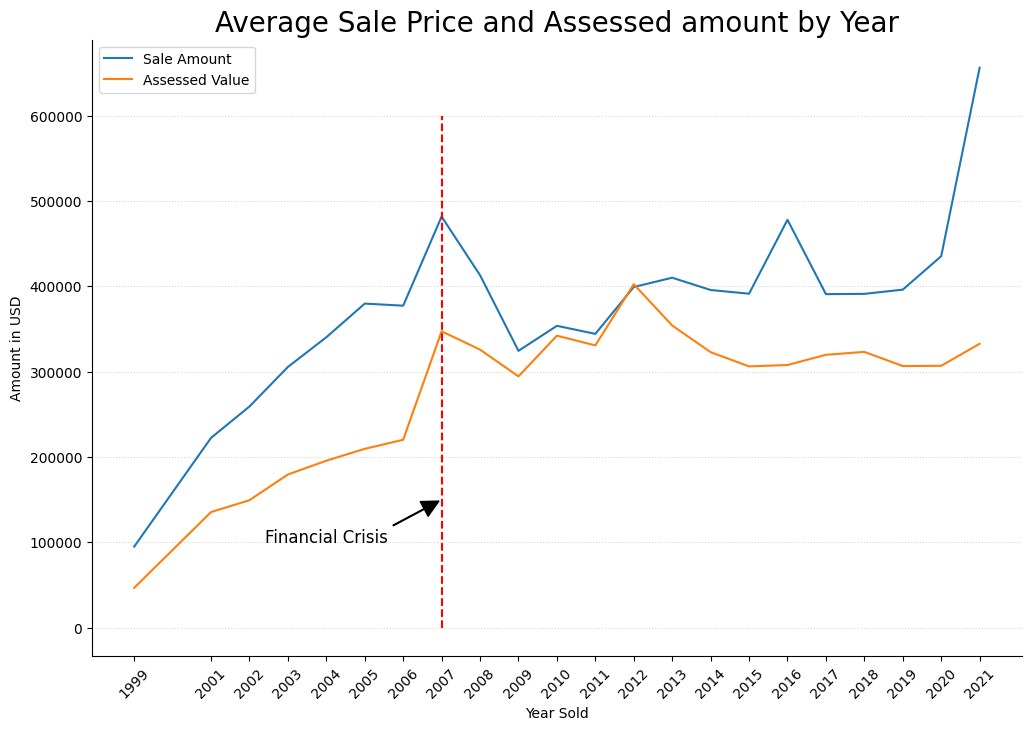

In [10]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_1,x='Year Sold',y='Sale Amount',errorbar=None,label='Sale Amount')
sns.lineplot(data=df_1,x='Year Sold',y='Assessed Value',errorbar=None,label='Assessed Value')

plt.xticks(df_1['Year Sold'].unique(),rotation=45)
plt.vlines(2007,ymin=0,ymax=600000,ls='--',color='red')
plt.annotate('Financial Crisis', xy=(2007, 150000), xytext=(2004, 100000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=12, ha='center')
sns.despine(top=True, right=True)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.legend()
plt.ylabel("Amount in USD")
plt.title('Average Sale Price and Assessed amount by Year',fontsize=20)

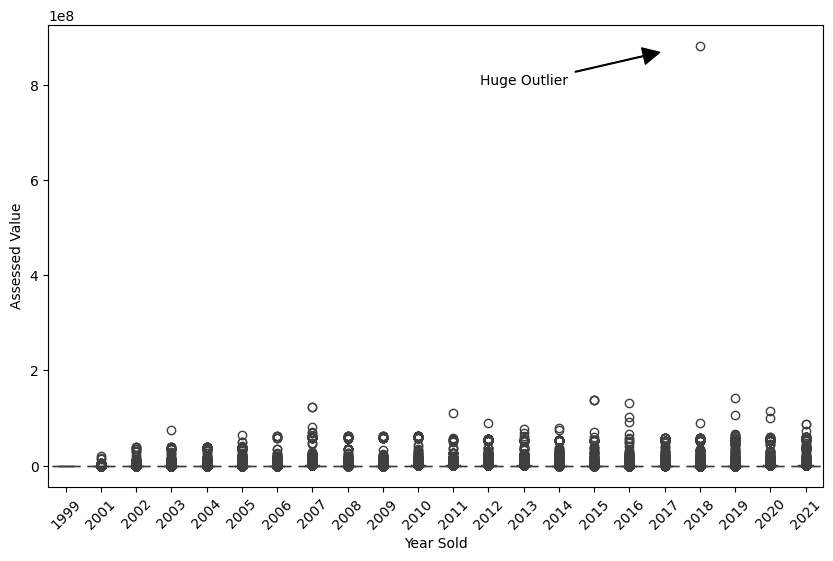

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_1,x='Year Sold',y='Assessed Value',)
plt.annotate('Huge Outlier', xy=(17, 870000000), xytext=(13, 800000000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=10, ha='center')
plt.xticks(rotation=45);

Text(15, 5000000000, 'Huge Outlier')

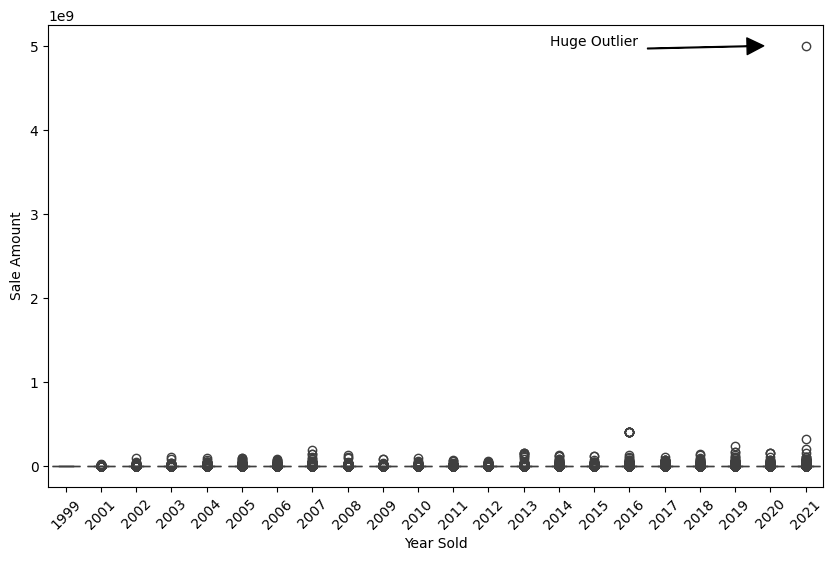

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_1,x='Year Sold',y='Sale Amount',)
plt.xticks(rotation=45)
plt.annotate('Huge Outlier', xy=(20, 5000000000), xytext=(15, 5000000000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=10, ha='center')

Text(0.5, 1.0, 'Average Sale Price by Year')

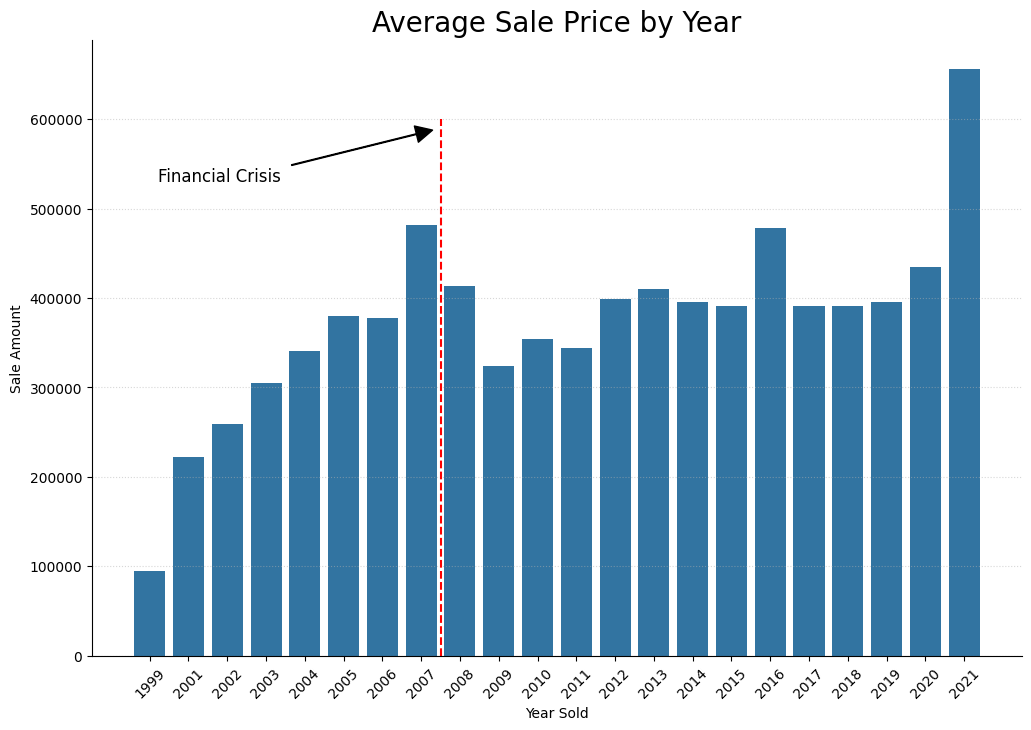

In [13]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_1,x='Year Sold',y='Sale Amount',errorbar=None)
plt.xticks(rotation=45)
plt.vlines(7.5,ymin=0,ymax=600000,ls='--',color='red')
plt.annotate('Financial Crisis', xy=(7.5, 590000), xytext=(1.8, 530000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=12, ha='center')
sns.despine(top=True, right=True)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.title('Average Sale Price by Year',fontsize=20)

Text(0.5, 1.0, 'Amount of Houses Sold by Year')

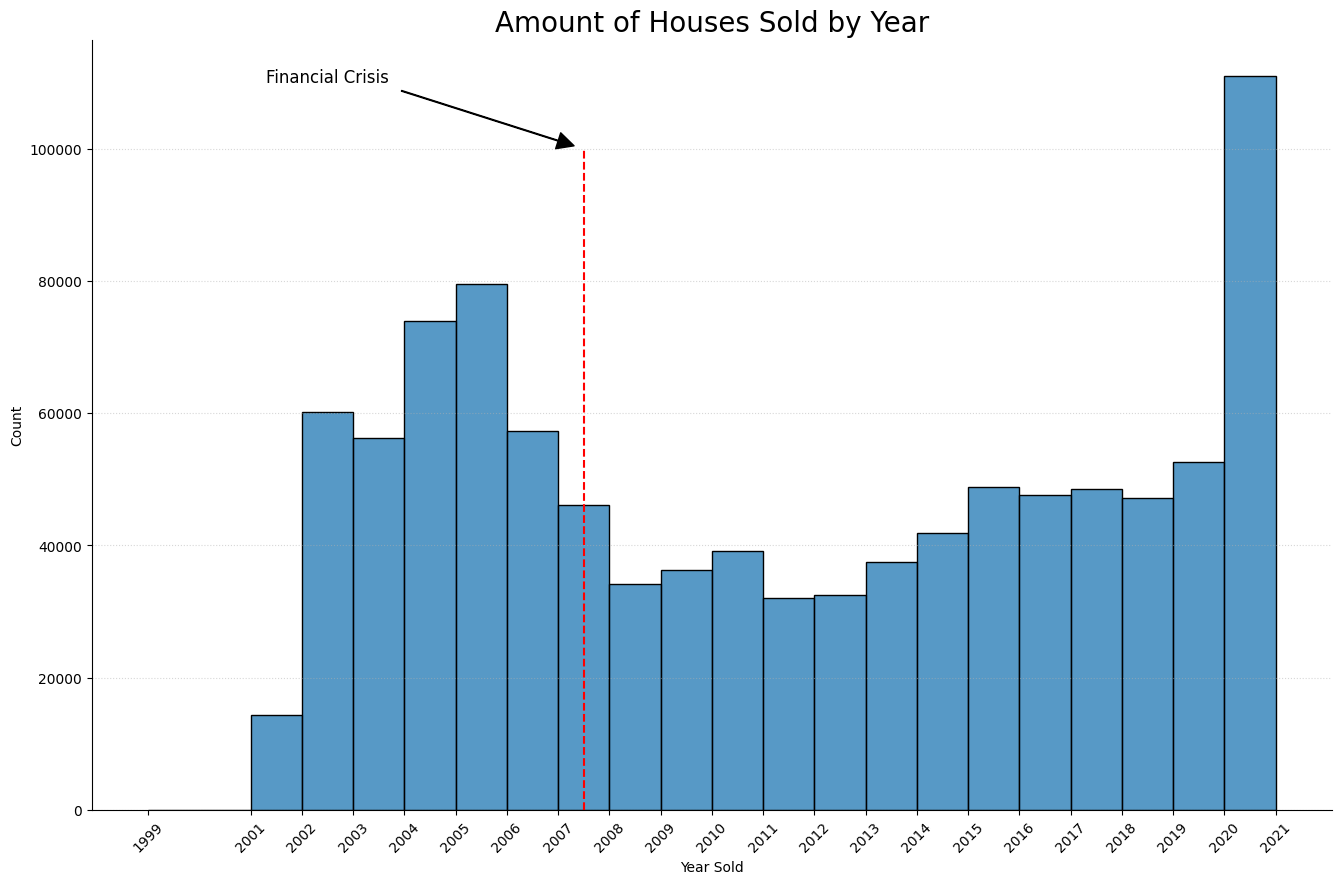

In [14]:
plt.figure(figsize=(16,10))
sns.histplot(data=df_1,x='Year Sold',bins=22)
plt.xticks(df_1['Year Sold'].unique(),rotation=45)
plt.xticks(rotation=45)
plt.vlines(2007.5,ymin=0,ymax=100000,ls='--',color='red')
plt.annotate('Financial Crisis', xy=(2007.5, 100000), xytext=(2002.5, 110000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=12, ha='center')
sns.despine(top=True, right=True)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.title('Amount of Houses Sold by Year',fontsize=20)

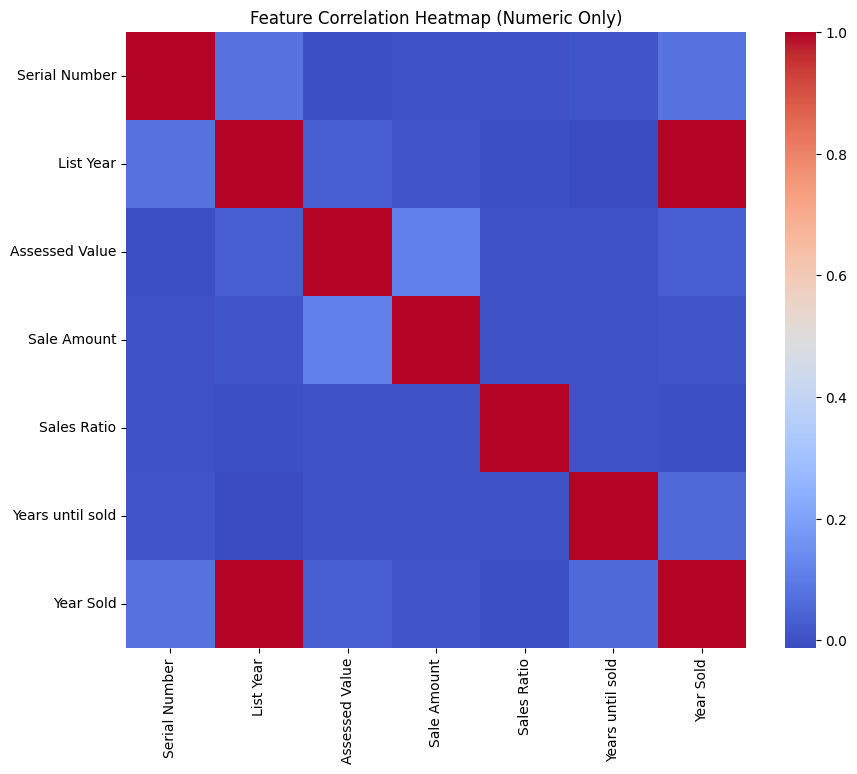

In [15]:
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap (Numeric Only)")
plt.show()



### Predict Model


In [16]:
#Import data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import time


In [17]:
#Now define the target and features for that

target_col = 'Sale Amount'
X = df.drop(columns=[target_col])
y = df[target_col]

# --- Drop unnecessary columns (unique identifiers)
drop_cols = ['Serial Number', 'Address']
X = X.drop(columns=drop_cols, errors='ignore')

# --- Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

Numeric features: ['List Year', 'Assessed Value', 'Sales Ratio', 'Years until sold', 'Year Sold']
Categorical features: ['Date Recorded', 'Town', 'Property Type', 'Residential Type']


In [18]:
#Define preprocessing (one-hot encode categorical features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [19]:
#Split the data into the trainning dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
#Create the pipeline: preprocessing + model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [21]:
#Train the model
print("\nTraining the Linear Regression Model...")
start = time.time()
model.fit(X_train, y_train)
end = time.time()
print(f"Training time: {end - start:.2f} seconds")



Training the Linear Regression Model...
Training time: 5.39 seconds


In [22]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n📊 Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:,.2f}")


📊 Model Performance:
R² Score: 0.1298
RMSE: 2,027,573.57


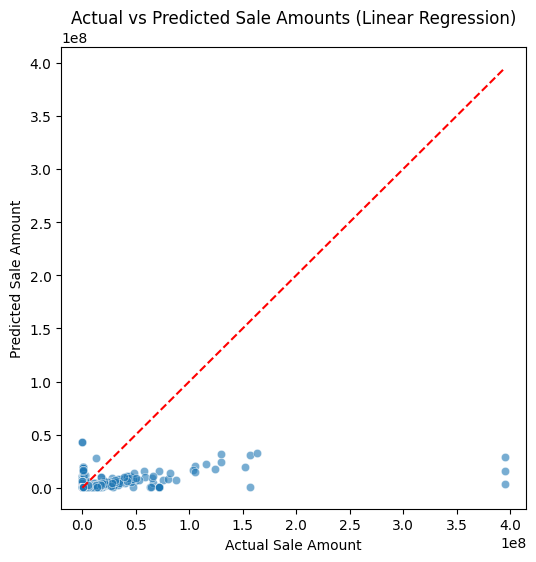

In [23]:
# --- Visualize actual vs predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Sale Amount")
plt.ylabel("Predicted Sale Amount")
plt.title("Actual vs Predicted Sale Amounts (Linear Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


In [24]:
pred_df = pd.DataFrame({
    'Actual Sale Amount': y_test.values,
    'Predicted Sale Amount': y_pred
})
print("\nSample Predictions:")
print(pred_df.head(10))


Sample Predictions:
   Actual Sale Amount  Predicted Sale Amount
0             56693.0          317802.592149
1             51000.0          342421.672334
2            105000.0          327117.083987
3            238000.0          344478.158746
4             10000.0          310974.438767
5             45000.0          328276.756774
6            385000.0          398089.058653
7            190000.0          373559.659826
8            127575.0          336069.757915
9            160000.0          336827.410804


In [25]:
#Next continue to update the Linear Regression part with other prediction graph
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [26]:
#1. FEATURE ENGINEERING WITH INFINITY HANDLING
def engineer_features(df):
    """
    Create new features that might enhance model performance
    """
    df_eng = df.copy()

    #
    # Create price_per_assessed (handling division by zero)
    df_eng['price_per_assessed'] = (
        df_eng['Sale Amount'] /
        df_eng['Assessed Value'].replace(0, np.nan)
    )

    # Replace inf values from division
    df_eng['price_per_assessed'] = df_eng['price_per_assessed'].replace([np.inf, -np.inf], np.nan)

    # Fill remaining NaN (optional, can choose median instead)
    df_eng['price_per_assessed'] = df_eng['price_per_assessed'].fillna(0)

    # Ensure 'Date Recorded' is datetime
    df_eng['Date Recorded'] = pd.to_datetime(df_eng['Date Recorded'], errors='coerce')

    df_eng['month_sold'] = df_eng['Date Recorded'].dt.month
    df_eng['quarter_sold'] = df_eng['Date Recorded'].dt.quarter

    df_eng['is_spring'] = df_eng['month_sold'].isin([3, 4, 5]).astype(int)
    df_eng['is_summer'] = df_eng['month_sold'].isin([6, 7, 8]).astype(int)

    town_avg_price = df_eng.groupby('Town')['Sale Amount'].mean().to_dict()
    df_eng['town_avg_price'] = df_eng['Town'].map(town_avg_price)

    df_eng['property_age'] = df_eng['Year Sold'] - df_eng['List Year']
    df_eng['property_age'] = df_eng['property_age'].clip(lower=0)  # Remove negatives

    return df_eng


In [27]:
#Apply feature engineering
df_enhanced = engineer_features(df_1)
print(f"Enhanced dataset shape: {df_enhanced.shape}")
print(f"New features created: {['price_per_assessed', 'month_sold', 'town_avg_price', 'property_age']}")


Enhanced dataset shape: (997213, 19)
New features created: ['price_per_assessed', 'month_sold', 'town_avg_price', 'property_age']


In [28]:
# Check for infinite values
print(f"\nChecking for infinite values:")
print(f"Infinite values in price_per_assessed: {np.isinf(df_enhanced['price_per_assessed']).sum()}")
print(f"NaN values in price_per_assessed: {df_enhanced['price_per_assessed'].isna().sum()}")



Checking for infinite values:
Infinite values in price_per_assessed: 0
NaN values in price_per_assessed: 0


In [29]:
# Data Preparation for Advanced Modeling
# Filter for residential properties only (as they are the majority)
df_residential = df_enhanced[df_enhanced['Property Type'] == 'Residential'].copy()

# Remove extreme outliers in Sale Amount (top and bottom 1%)
lower_bound = df_residential['Sale Amount'].quantile(0.01)
upper_bound = df_residential['Sale Amount'].quantile(0.99)
df_clean = df_residential[(df_residential['Sale Amount'] >= lower_bound) &
                         (df_residential['Sale Amount'] <= upper_bound)].copy()

# Also remove outliers in Assessed Value to avoid division issues
assessed_lower = df_clean['Assessed Value'].quantile(0.01)
assessed_upper = df_clean['Assessed Value'].quantile(0.99)
df_clean = df_clean[(df_clean['Assessed Value'] >= assessed_lower) &
                   (df_clean['Assessed Value'] <= assessed_upper)].copy()

print(f"After filtering residential and outliers: {df_clean.shape}")

After filtering residential and outliers: (588978, 19)


In [30]:

# Define features and target
features = ['Assessed Value', 'Sales Ratio', 'Years until sold', 'Year Sold',
           'Residential Type', 'Town', 'price_per_assessed',
           'month_sold', 'town_avg_price', 'property_age', 'is_spring', 'is_summer']

target = 'Sale Amount'

# Prepare the data
X = df_clean[features]
y = df_clean[target]

# Final check for any remaining infinite or NaN values
print(f"\nFinal data quality check:")
print(f"Total NaN values in X: {X.isna().sum().sum()}")
print(f"Total infinite values in X: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}")


Final data quality check:
Total NaN values in X: 0
Total infinite values in X: 0


In [31]:
# Remove any remaining rows with NaN values
X = X.dropna()
y = y.loc[X.index]

print(f"Final dataset shape: {X.shape}")

Final dataset shape: (588978, 12)


In [32]:
# Identify categorical and numerical features
categorical_features = ['Residential Type', 'Town']
numerical_features = [col for col in features if col not in categorical_features]

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")


Categorical features: ['Residential Type', 'Town']
Numerical features: ['Assessed Value', 'Sales Ratio', 'Years until sold', 'Year Sold', 'price_per_assessed', 'month_sold', 'town_avg_price', 'property_age', 'is_spring', 'is_summer']


In [33]:

# 3. CREATE PREPROCESSING PIPELINE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])


In [34]:
# 4. IMPLEMENT ALL MODELS
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42, max_iter=1000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Store results
results = {}
feature_importances = {}

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (471182, 12)
Test set shape: (117796, 12)


In [35]:

print("\n=== TRAINING MODELS ===")

for name, model in models.items():
    print(f"Training {name}...")

    try:
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        # Train model
        pipeline.fit(X_train, y_train)

        # Predictions
        y_pred = pipeline.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[name] = {
            'model': pipeline,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'predictions': y_pred
        }

        # Get feature importances for tree-based models
        if name in ['Random Forest', 'XGBoost']:
            # Get feature names after one-hot encoding
            preprocessor_temp = preprocessor.fit(X_train)
            feature_names = numerical_features.copy()
            cat_encoder = preprocessor_temp.named_transformers_['cat']
            cat_features = cat_encoder.get_feature_names_out(categorical_features)
            feature_names.extend(cat_features)

            if name == 'Random Forest':
                importances = pipeline.named_steps['regressor'].feature_importances_
            else:  # XGBoost
                importances = pipeline.named_steps['regressor'].feature_importances_

            feature_importances[name] = {
                'features': feature_names,
                'importances': importances
            }

        print(f" {name} - RMSE: ${rmse:,.2f}, MAE: ${mae:,.2f}, R²: {r2:.4f}")

    except Exception as e:
        print(f" {name} failed: {str(e)}")
        continue


=== TRAINING MODELS ===
Training Linear Regression...
 Linear Regression - RMSE: $95,310.14, MAE: $44,650.70, R²: 0.8709
Training Lasso Regression...
 Lasso Regression - RMSE: $95,309.61, MAE: $44,638.03, R²: 0.8709
Training Random Forest...
 Random Forest - RMSE: $3,998.20, MAE: $437.32, R²: 0.9998
Training XGBoost...
 XGBoost - RMSE: $14,652.05, MAE: $4,890.64, R²: 0.9969


In [36]:
# 5. COMPREHENSIVE MODEL EVALUATION
print("\n=== MODEL COMPARISON ===")


=== MODEL COMPARISON ===


               Model          RMSE           MAE        R²
2      Random Forest   3998.203736    437.320215  0.999773
3            XGBoost  14652.050538   4890.644600  0.996950
1   Lasso Regression  95309.614540  44638.031075  0.870942
0  Linear Regression  95310.137586  44650.699954  0.870941


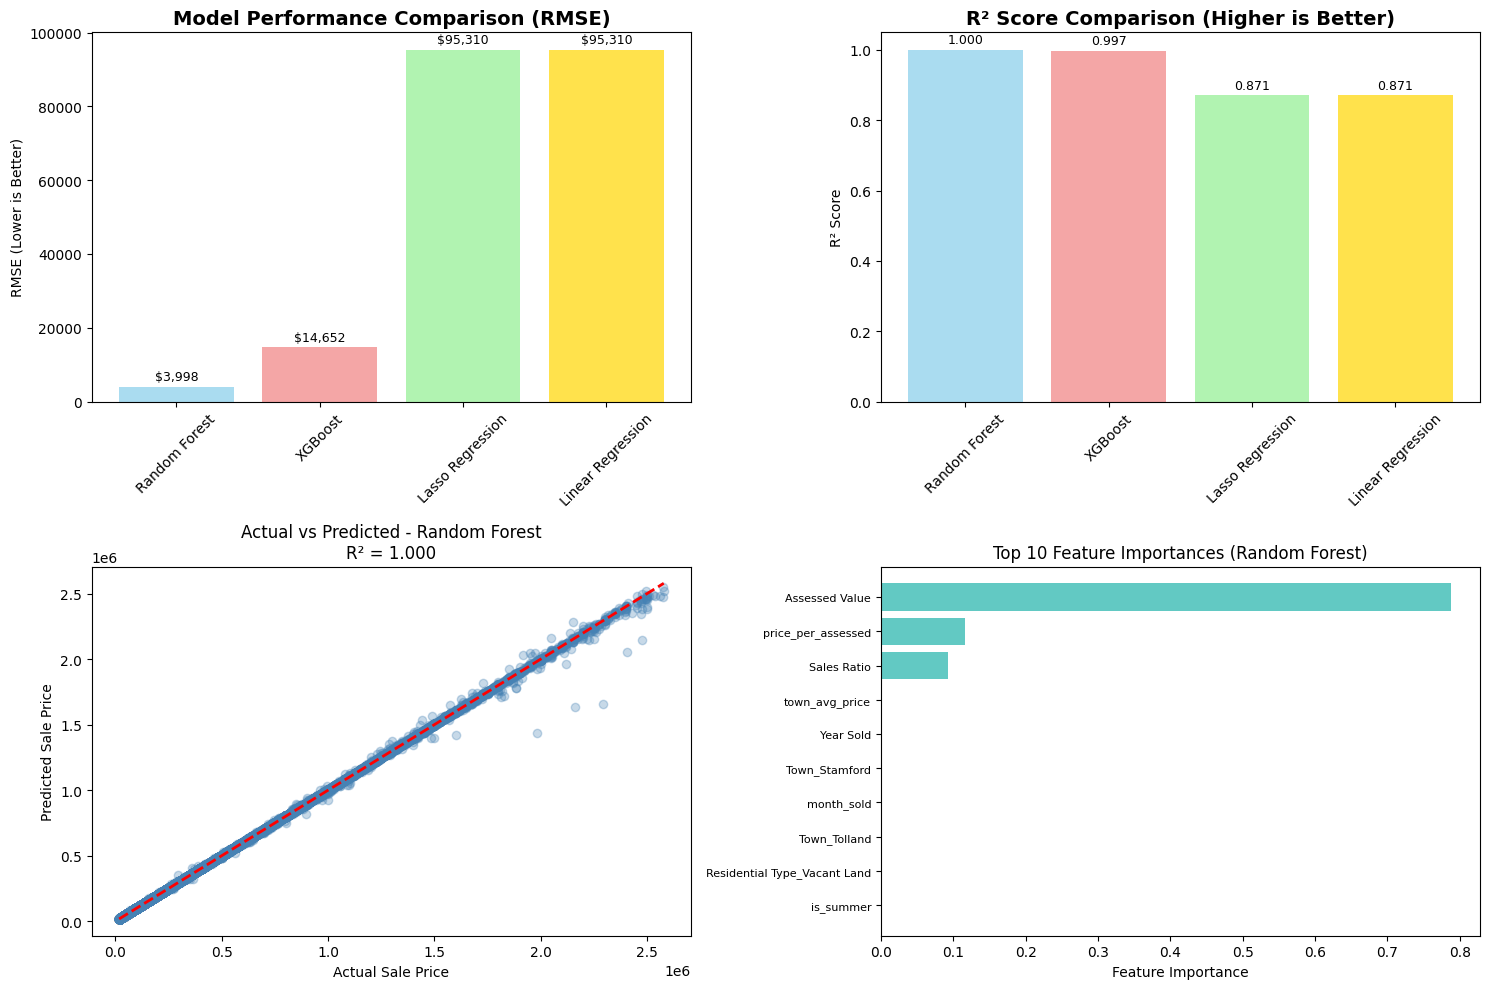

In [37]:
if results:
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'RMSE': [results[model]['rmse'] for model in results.keys()],
        'MAE': [results[model]['mae'] for model in results.keys()],
        'R²': [results[model]['r2'] for model in results.keys()]
    }).sort_values('RMSE')

    print(comparison_df)

    # 6. VISUALIZATION OF RESULTS
    plt.figure(figsize=(15, 10))

    # Plot 1: Model Performance Comparison
    plt.subplot(2, 2, 1)
    models_list = comparison_df['Model']
    rmse_scores = comparison_df['RMSE']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

    bars = plt.bar(models_list, rmse_scores, color=colors[:len(models_list)], alpha=0.7)
    plt.title('Model Performance Comparison (RMSE)', fontsize=14, fontweight='bold')
    plt.ylabel('RMSE (Lower is Better)')
    plt.xticks(rotation=45)
    # Add value labels on bars
    for bar, value in zip(bars, rmse_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                 f'${value:,.0f}', ha='center', va='bottom', fontsize=9)

    # Plot 2: R² Scores Comparison
    plt.subplot(2, 2, 2)
    r2_scores = comparison_df['R²']
    bars = plt.bar(models_list, r2_scores, color=colors[:len(models_list)], alpha=0.7)
    plt.title('R² Score Comparison (Higher is Better)', fontsize=14, fontweight='bold')
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)
    # Add value labels on bars
    for bar, value in zip(bars, r2_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{value:.3f}', ha='center', va='bottom', fontsize=9)

    # Plot 3: Actual vs Predicted for Best Model
    best_model_name = comparison_df.iloc[0]['Model']
    best_model = results[best_model_name]['model']
    y_pred_best = results[best_model_name]['predictions']

    plt.subplot(2, 2, 3)
    plt.scatter(y_test, y_pred_best, alpha=0.3, color='steelblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Sale Price')
    plt.ylabel('Predicted Sale Price')
    plt.title(f'Actual vs Predicted - {best_model_name}\nR² = {results[best_model_name]["r2"]:.3f}')

    # Plot 4: Feature Importance for Best Tree-based Model
    plt.subplot(2, 2, 4)
    tree_models = [name for name in ['Random Forest', 'XGBoost'] if name in feature_importances]
    if tree_models:
        # Use the first available tree-based model
        model_name = tree_models[0]
        importances_data = feature_importances[model_name]

        # Get top 10 features
        top_idx = np.argsort(importances_data['importances'])[-10:]
        top_features = [importances_data['features'][i] for i in top_idx]
        top_importance = importances_data['importances'][top_idx]

        # Shorten long feature names for display
        top_features_short = [f[:30] + '...' if len(f) > 30 else f for f in top_features]

        plt.barh(range(len(top_features)), top_importance, color='lightseagreen', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features_short, fontsize=8)
        plt.xlabel('Feature Importance')
        plt.title(f'Top 10 Feature Importances ({model_name})')

    plt.tight_layout()
    plt.show()


In [38]:
# 7. FINAL MODEL INTERPRETATION AND INSIGHTS
print("\n=== FINAL MODEL INSIGHTS ===")

    # Select best model
final_model_name = comparison_df.iloc[0]['Model']
final_model = results[final_model_name]['model']
final_metrics = results[final_model_name]

print(f" BEST MODEL: {final_model_name}")
print(f" Final Performance:")
print(f"   - RMSE: ${final_metrics['rmse']:,.2f}")
print(f"   - MAE: ${final_metrics['mae']:,.2f}")
print(f"   - R²: {final_metrics['r2']:.4f}")


=== FINAL MODEL INSIGHTS ===
 BEST MODEL: Random Forest
 Final Performance:
   - RMSE: $3,998.20
   - MAE: $437.32
   - R²: 0.9998


In [39]:
#Feature importance analysis
if final_model_name in feature_importances:
    print(f"\n TOP 5 MOST IMPORTANT FEATURES ({final_model_name}):")
    importances = feature_importances[final_model_name]
    top_5_idx = np.argsort(importances['importances'])[-5:]

    for i in top_5_idx[::-1]:  # Reverse to show most important first
        feature = importances['features'][i]
        importance = importances['importances'][i]
        print(f"   - {feature}: {importance:.4f}")


 TOP 5 MOST IMPORTANT FEATURES (Random Forest):
   - Assessed Value: 0.7886
   - price_per_assessed: 0.1165
   - Sales Ratio: 0.0932
   - town_avg_price: 0.0014
   - Year Sold: 0.0001


In [40]:
# 8. CROSS-VALIDATION FOR ROBUSTNESS
print("\n=== CROSS-VALIDATION RESULTS ===")
cv_scores = {}
    # Use a smaller sample for faster cross-validation
X_sample = X.sample(n=min(10000, len(X)), random_state=42)
y_sample = y.loc[X_sample.index]

for name in results.keys():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', models[name])
        ])

    try:
        # 3-fold cross validation for speed
        cv_rmse = np.sqrt(-cross_val_score(pipeline, X_sample, y_sample,
                                             cv=3, scoring='neg_mean_squared_error'))
        cv_scores[name] = cv_rmse
        print(f"{name} - CV RMSE: ${cv_rmse.mean():,.2f} (±${cv_rmse.std():,.2f})")
    except Exception as e:
          print(f"{name} - CV failed: {str(e)}")


=== CROSS-VALIDATION RESULTS ===
Linear Regression - CV RMSE: $96,036.82 (±$9,554.50)
Lasso Regression - CV RMSE: $96,006.44 (±$9,566.50)
Random Forest - CV RMSE: $33,316.47 (±$11,142.82)
XGBoost - CV RMSE: $32,880.33 (±$9,833.80)


In [41]:
# 9. SAVE THE FINAL MODEL
import joblib

 # Save the best model
model_filename = f'best_house_price_model_{final_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(final_model, model_filename)
print(f"\n Best model saved as: {model_filename}")


 Best model saved as: best_house_price_model_random_forest.pkl


In [42]:
if len(results) > 0:
    # === SAMPLE PREDICTION ===
    print("\n=== SAMPLE PREDICTION ===")
    sample_idx = X_test.index[0]
    sample_data = X_test.loc[sample_idx:sample_idx]
    actual_price = y_test.loc[sample_idx]
    predicted_price = final_model.predict(sample_data)[0]

    print(f"Sample Property Details:")
    for feature in ['Town', 'Residential Type', 'Assessed Value', 'Year Sold']:
        print(f"  {feature}: {sample_data[feature].iloc[0]}")
    print(f"Actual Sale Price: ${actual_price:,.2f}")
    print(f"Predicted Sale Price: ${predicted_price:,.2f}")
    print(f"Prediction Error: ${abs(actual_price - predicted_price):,.2f}")
    print(f"Error Percentage: {abs(actual_price - predicted_price)/actual_price*100:.1f}%")

    print("\nPROJECT COMPLETION SUMMARY:")
    print(" All models implemented and evaluated")
    print(" Feature engineering completed")
    print(" Comprehensive model comparison done")
    print(" Best model selected and interpreted")
    print(" Cross-validation performed")
    print(" Model saved for future use")
    print(" Visualizations created for presentation")

else:
    print("No models were successfully trained. Please check the data quality.")



=== SAMPLE PREDICTION ===
Sample Property Details:
  Town: Farmington
  Residential Type: Single Family
  Assessed Value: 507500
  Year Sold: 2021
Actual Sale Price: $880,000.00
Predicted Sale Price: $880,418.88
Prediction Error: $418.88
Error Percentage: 0.0%

PROJECT COMPLETION SUMMARY:
 All models implemented and evaluated
 Feature engineering completed
 Comprehensive model comparison done
 Best model selected and interpreted
 Cross-validation performed
 Model saved for future use
 Visualizations created for presentation
